In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test_fin = test_data['data']

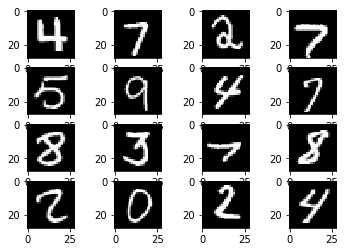

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

# Подготовка датасета

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.2, 
                                                    random_state=12, stratify=Y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=12)

In [8]:
mu = np.mean(X_train)
std = np.std(X_train)
eps = 1e-5

In [9]:
X_train = (X_train - mu) / (std + eps)
X_val = (X_val - mu) / (std + eps)
X_test = (X_test - mu) / (std + eps)
X_test_fin = (X_test_fin - mu) / (std + eps)

# Определение слоев сети

In [76]:
class Dense():
    
    def __init__(self, in_size, out_size, learning_rate):
        self.lr = learning_rate
        self.W = np.random.normal(scale=1, size=[in_size, out_size]) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout, lr):
        self.lr = lr
        x = self.x
        w = self.W
        db = np.sum(dout, axis=0)
        dw = np.dot(x.T, dout)
        dx = np.dot(dout, w.T)
        
        self.W = self.W - self.lr * dw
        self.b = self.b - self.lr * db
        
        return dx

In [77]:
class ReLu(): 

    def forward(self, x):
        out = np.maximum(0, x)
        self.mask = out
        return out

    def backward(self, dout):
        mask = self.mask > 0
        dout = dout * mask
        return dout

In [78]:
class Dropout():
    
    def __init__(self, prob):
        self.prob = prob
    
    def forward(self, x):
        p = self.prob
        mask = (np.random.rand(*x.shape) < p) / p 
        out = x * mask
        self.mask = mask
        return out

    def backward(self, dout):
        dx = dout * self.mask
        return dx

In [79]:
class CrossEntropy():
    
    def forward(self, x, y):
        shifted_logits = x - np.max(x, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)
        N = x.shape[0]
        idxs = np.argmax(y, axis=1)
        loss = -np.sum(log_probs[np.arange(N), idxs]) / N
        
        self.probs = probs
        self.y = idxs
        self.N = N
        return loss
    
    def backward(self):
        dz = self.probs
        dz[np.arange(self.N), self.y] -= 1
        dz /= self.N
        return dz

In [80]:
def calc_acc(scores, y):
    acc = 0.0
    idxs = np.argmax(scores, axis=1)
    y_true = np.argmax(y, axis=1)
    acc = np.sum(idxs == y_true)
    return acc / y.shape[0]

# Опеределение самой сети

In [81]:
class MnistNet():
    def __init__(self, in_size, hidden_sizes, out_size, loss=CrossEntropy(),
                 learning_rate=1e-4, prob=1, lr_decay=1, mode='test'):
        self.loss = loss
        self.mode = mode
        self.lr = learning_rate
        self.prob = prob
        self.decay = lr_decay
        
        self.dense_l = []
        self.relu_l = []
        self.dropout_l = []
    
        sizes = np.hstack((in_size, hidden_sizes, out_size))
        for i in range(len(sizes) - 1):
            in_size = sizes[i]
            out_size = sizes[i+1]
            
            self.dense_l.append(Dense(in_size, out_size, self.lr))
            if(i < len(sizes) - 2):
                self.relu_l.append(ReLu())
                self.dropout_l.append(Dropout(self.prob))
        
        
    def forward(self, x):
        batch = copy.deepcopy(x)
        
        if(self.mode == 'train'):
            for n in range(len(self.relu_l)):
                batch = self.dense_l[n].forward(batch)
                batch = self.relu_l[n].forward(batch)
                batch = self.dropout_l[n].forward(batch)
        else:
            for n in range(len(self.relu_l)):
                batch = self.dense_l[n].forward(batch)
                batch = self.relu_l[n].forward(batch)
        
        n += 1
        batch = self.dense_l[n].forward(batch)
        return batch
   

    def backward(self, dz):       
        dout = self.dense_l[-1].backward(dz, self.lr)
        
        for i in range(len(self.dense_l) - 2, -1, -1):
            dout = self.dropout_l[i].backward(dout)
            dout = self.relu_l[i].backward(dout)
            dout = self.dense_l[i].backward(dout, self.lr)
        return dout
    
    def fit(self, x, y, x_val, y_val, batch_size=20, epoches=30):
        self.mode = 'train'
        iter_per_ep = x.shape[0] // batch_size
        losses = []
        accs = []
        losses_val = []
        accs_val = []
        for ep in range(epoches):
            print('epoch:', ep)
            for i in range(iter_per_ep):
                batch = copy.deepcopy(x)
                idx = np.random.randint(low=0, high=x.shape[0], size=batch_size)
                batch = x[idx]
                batch_y = y[idx]
                scores = self.forward(batch)
                lo = self.loss.forward(scores, batch_y)
                dz = 1
                dz = self.loss.backward()
                dz = self.backward(dz)
            
            self.lr *= self.decay
            scores = self.forward(x)
            losses.append(self.loss.forward(scores, y))
            accs.append(calc_acc(scores, y))
            
            scores = self.forward(x_val)
            losses_val.append(self.loss.forward(scores, y_val))
            acc = calc_acc(scores, y_val)
            accs_val.append(acc)
            
            print('iteration:', (ep+1) * iter_per_ep, '/', 
                  epoches * iter_per_ep, 'val accuracy:', acc)
            
        return (losses, accs), (losses_val, accs_val)
    
    def predict(self, x):
        self.mode = 'test'
        return self.forward(x)

# Обученне сети

In [82]:
net = MnistNet(X_train.shape[1], [400, 200], 10, learning_rate=1e-1, prob=0.5, lr_decay=0.95)
losses, losses_val = net.fit(X_train, y_train, X_val, y_val, batch_size=20, epoches=30)

epoch: 0
iteration: 1680 / 50400 val accuracy: 0.8827380952380952
epoch: 1
iteration: 3360 / 50400 val accuracy: 0.9127380952380952
epoch: 2
iteration: 5040 / 50400 val accuracy: 0.9238095238095239
epoch: 3
iteration: 6720 / 50400 val accuracy: 0.9320238095238095
epoch: 4
iteration: 8400 / 50400 val accuracy: 0.9336904761904762
epoch: 5
iteration: 10080 / 50400 val accuracy: 0.9453571428571429
epoch: 6
iteration: 11760 / 50400 val accuracy: 0.944047619047619
epoch: 7
iteration: 13440 / 50400 val accuracy: 0.944047619047619
epoch: 8
iteration: 15120 / 50400 val accuracy: 0.9508333333333333
epoch: 9
iteration: 16800 / 50400 val accuracy: 0.9480952380952381
epoch: 10
iteration: 18480 / 50400 val accuracy: 0.9514285714285714
epoch: 11
iteration: 20160 / 50400 val accuracy: 0.9519047619047619
epoch: 12
iteration: 21840 / 50400 val accuracy: 0.9532142857142857
epoch: 13
iteration: 23520 / 50400 val accuracy: 0.9529761904761904
epoch: 14
iteration: 25200 / 50400 val accuracy: 0.95428571428571

# Анализ результатов

In [90]:
scores = net.predict(X_test)
calc_acc(scores, y_test)

0.9752380952380952

In [84]:
loss, accs = losses
loss_val, accs_val = losses_val

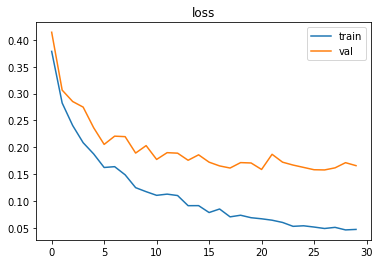

In [85]:
plt.title('loss')
plt.plot(loss, label='train')
plt.plot(loss_val, label='val')
plt.legend()

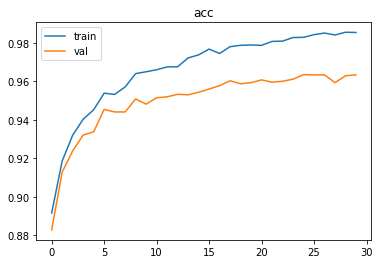

In [86]:
plt.title('acc')
plt.plot(accs, label='train')
plt.plot(accs_val, label='val')
plt.legend()

In [87]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_fin, net)